In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import linregress
from scipy.stats import linregress
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f_oneway
import seaborn as sns



# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

# 독립 변수별 관중수와의 유의미성 확인

## 1. 기온(날씨)와 관중수의 관계 분석

목표
:경기시 온도가 관중 수에 어떤 영향을 미치는지 분석하여, 날씨 조건이 관중 수 변화에 중요한 요인인지 파악.

- 분석 방법: 상관 분석: 기온과 관중수 간의 상관계수를 계산.
- 단순 회귀 분석: 기온이 관중수에 미치는 영향을 정량적으로 측정.

->  기대 결과:
기온이 높거나 온화한 날씨에서 관중수가 증가하는 경향 확인.


피어슨 상관계수: 0.06
회귀식: 관중수 = 73.92 * 기온 + 8952.17
평균 제곱 오차(MSE): 44889314.54
결정 계수(R²): 0.00


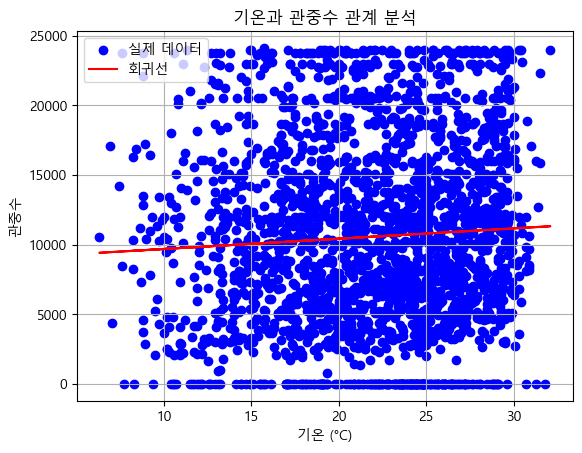

In [12]:
file_path = "시즌경기_정제완료.xlsx"
df = pd.read_excel(file_path)

# 데이터 확인
#print(df.head())

# 분석에 사용할 데이터만 추출 (기온과 관중수)
df = df[['기온', '관중수']]

temperature_col = "기온"  # 기온 컬럼명
audience_col = "관중수"  # 관중수 컬럼명

df[temperature_col] = df[temperature_col].replace(',', '', regex=True).astype(float)
df[audience_col] = df[audience_col].replace(',', '', regex=True).astype(float)

# 상관 분석 (Pearson correlation)
correlation, _ = pearsonr(df[temperature_col], df[audience_col])
print(f"피어슨 상관계수: {correlation:.2f}")

# 회귀 분석
X = df[[temperature_col]]  # 독립 변수 (기온)
y = df[audience_col]  # 종속 변수 (관중수)

# 모델 생성 및 학습
model = LinearRegression()
model.fit(X, y)

# 회귀 결과
y_pred = model.predict(X)
slope = model.coef_[0]  # 기울기
intercept = model.intercept_  # 절편
mse = mean_squared_error(y, y_pred)  # 평균 제곱 오차
r2 = r2_score(y, y_pred)  # 결정 계수

# 결과 출력
print(f"회귀식: 관중수 = {slope:.2f} * 기온 + {intercept:.2f}") # 관중수 = 0.00 * 기온 + 0.00
print(f"평균 제곱 오차(MSE): {mse:.2f}") # 평균 제곱 오차(MSE): 0.00
print(f"결정 계수(R²): {r2:.2f}") # 결정 계수(R²): 0.00

# 데이터 시각화
plt.scatter(df[temperature_col], df[audience_col], color='blue', label='실제 데이터')
plt.plot(df[temperature_col], y_pred, color='red', label='회귀선')
plt.title('기온과 관중수 관계 분석')
plt.xlabel('기온 (°C)')
plt.ylabel('관중수')
plt.legend()
plt.grid(True)
plt.show()



상관관계가 거의 없고 오차가 너무 크기 때문에 기온이 관중수에 영향을 미치지 않다고 판단.

-> 보조적 변수로 사용하기 위해 5도 간격으로 평균 관중수 계산

   기온 그룹        평균 관중수
0    5.0  10319.222222
1   10.0   9809.715447
2   15.0  10712.557439
3   20.0  10042.378906
4   25.0  11198.251029
5   30.0  12249.476190


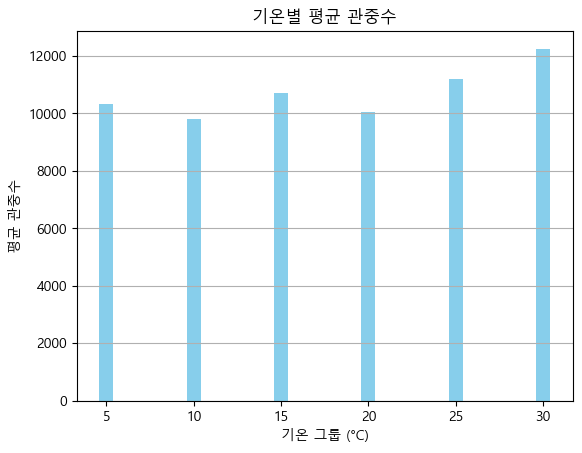

In [15]:
# 기온을 5도 간격으로 그룹화
df['기온 그룹'] = (df['기온'] // 5) * 5  # 기온을 5로 나누고 내림 처리하여 그룹화

# 그룹별 평균 관중수 계산
grouped = df.groupby('기온 그룹')['관중수'].mean().reset_index()
grouped.rename(columns={'관중수': '평균 관중수'}, inplace=True)

# 결과 출력
print(grouped)

# 데이터 시각화
plt.bar(grouped['기온 그룹'], grouped['평균 관중수'], color='skyblue')
plt.title('기온별 평균 관중수')
plt.xlabel('기온 그룹 (°C)')
plt.ylabel('평균 관중수')
plt.grid(axis='y')
plt.show()


경기시 온도가 관중수에 어떤 영향을 미치는지 알아보기 위해서 기온과 관중수의 회귀 분석을 진행했다. 회귀분석 결과, 두 변수간의 선형 상관 관계를 설명해주는 피어슨 상관계수는 거의 0에 수렴하는 0.06으로, 상관관계가 없는 것으로 나타났다. 즉, 관중수의 변동을 설명하기 위해서는 다른 변수를 고려해야 할 필요가 있다. 

## 2. 현장 이벤트 유무와 관중수의 관계 분석

분석 방법:
- t-검정: 이벤트 유무에 따른 평균 관중수 차이 분석.
- ANOVA: 구단별 이벤트 효과성 검증.

-> 기대 결과: 이벤트(예: 불꽃놀이, 셀럽 시구)가 관중수에 긍정적 영향을 미칠 것으로 예상.


          날짜    홈      관중수  현장이벤트
0 2022-04-02   두산  16271.0      0
1 2022-04-02  KIA  16908.0      0
2 2022-04-02   키움   8257.0      0
3 2022-04-02   NC   7814.0      0
4 2022-04-02   KT  17057.0      0
이벤트 유무에 따른 평균 관중 수:
이벤트 있는 날 평균 관중 수: 12068.11
이벤트 없는 날 평균 관중 수: 9947.40
t-검정 통계량: 7.05
p-value: 0.00


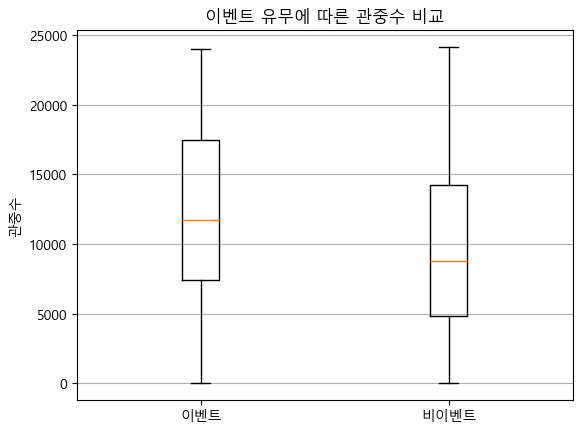

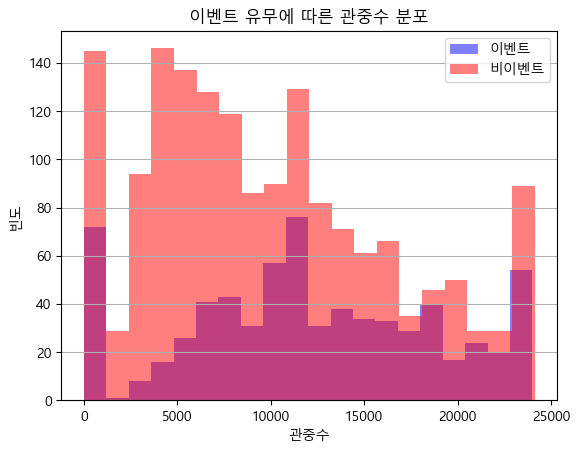

In [38]:
date = '시즌경기_정제완료.xlsx'
event = '현장이벤트.xlsx'

df_date = pd.read_excel(date, usecols=['날짜', '홈','관중수'])
df_date['날짜'] = pd.to_datetime(df_date['날짜'])
df_date['관중수'] = pd.to_numeric(df_date['관중수'], errors='coerce').fillna(0) # 관중수 데이터 타입 변경

event = pd.read_excel(event)

event_melted = event.melt(id_vars=['날짜'], var_name='홈', value_name='현장이벤트')  # 데이터 재구조화

merged_data = pd.merge(df_date, event_melted, on=['날짜', '홈'], how='inner') # 데이터 병합

print(merged_data.head()) # 데이터 확인

# 이벤트 유무에 따른 관중 수 비교
event_days = merged_data[merged_data['현장이벤트'] == 1]['관중수']
no_event_days = merged_data[merged_data['현장이벤트'] == 0]['관중수']

# 평균 관중 수 비교

print("이벤트 유무에 따른 평균 관중 수:")
print(f"이벤트 있는 날 평균 관중 수: {event_days.mean():.2f}")
print(f"이벤트 없는 날 평균 관중 수: {no_event_days.mean():.2f}")

# t-검정
t_stat, p_value = ttest_ind(event_days, no_event_days)
print(f"t-검정 통계량: {t_stat:.2f}")
print(f"p-value: {p_value:.2f}")

# 시각화
plt.boxplot([event_days, no_event_days])
plt.xticks([1, 2], ['이벤트', '비이벤트'])
plt.ylabel('관중수')
plt.title('이벤트 유무에 따른 관중수 비교')
plt.grid(axis='y')
plt.show()

# 다른 시각화 
plt.hist(event_days, bins=20, alpha=0.5, color='b', label='이벤트')
plt.hist(no_event_days, bins=20, alpha=0.5, color='r', label='비이벤트')
plt.legend()
plt.xlabel('관중수')
plt.ylabel('빈도')
plt.title('이벤트 유무에 따른 관중수 분포')
plt.grid(axis='y')
plt.show()

이벤트 유무에 따른 상관관계는 유의미하지 않음.(비이벤트에도 관중수가 많다는 의미) 이벤트 유무에 따라 평균 관중 수 데이터는 보조 도구로 사용가능할거같음.

In [ ]:
# 구단별 이벤트 효과 분석

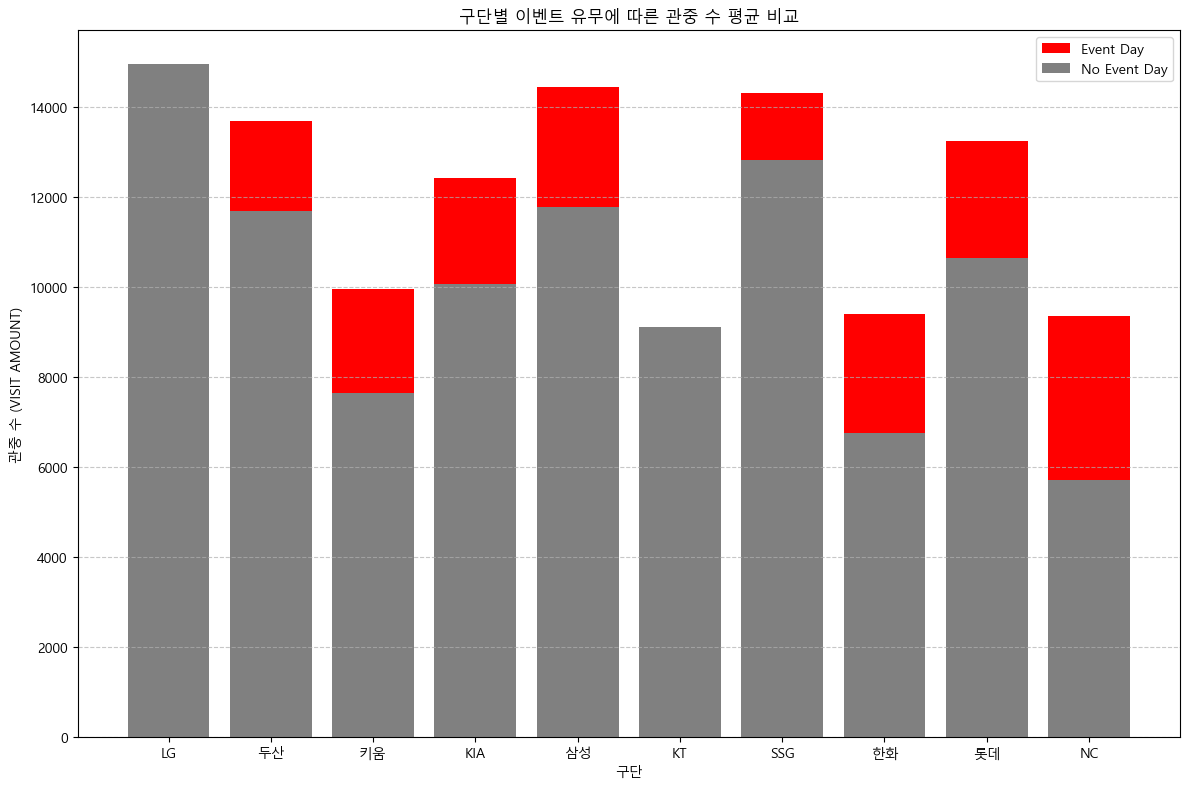

구단별 이벤트 효과 분석 결과:
    구단     이벤트_있음_평균     이벤트_없음_평균       p-value
0   LG  13353.080460  14956.234177  9.026845e-02
1   두산  13691.821429  11685.967105  6.492966e-02
2   키움   9962.025000   7639.522727  1.877915e-03
3  KIA  12432.794118  10068.247664  5.380060e-02
4   삼성  14439.656716  11774.615385  1.499179e-02
5   KT   8149.359551   9114.804054  1.665953e-01
6  SSG  14314.810526  12835.132867  8.427580e-02
7   한화   9402.428571   6768.800000  4.963407e-04
8   롯데  13248.678571  10651.951724  6.524761e-03
9   NC   9360.578947   5707.491124  5.218095e-07


In [ ]:
# 구단 리스트 설정
teams = ['LG', '두산', '키움', 'KIA', '삼성', 'KT', 'SSG', '한화', '롯데', 'NC']

# Step 5: 구단별 이벤트 효과 분석
results = []  # 결과 저장
plt.figure(figsize=(12, 8))

for team in teams:
    team_data = merged_data[merged_data['홈'] == team]
    event_days = team_data[team_data['현장이벤트'] == 1]['관중수']
    no_event_days = team_data[team_data['현장이벤트'] == 0]['관중수']
    
    # 평균 비교
    event_mean = event_days.mean()
    no_event_mean = no_event_days.mean()
    
    # T-test 수행
    if len(event_days) > 1 and len(no_event_days) > 1:  # 데이터가 충분한 경우만 실행
        t_stat, p_value = ttest_ind(event_days, no_event_days, equal_var=False)
    else:
        t_stat, p_value = None, None
    
    # 결과 저장
    results.append({
        '구단': team,
        '이벤트_있음_평균': event_mean,
        '이벤트_없음_평균': no_event_mean,
        'p-value': p_value
    })
    
    # 시각화 (막대 그래프)
    plt.bar(team, event_mean, color='red', label='Event Day' if team == teams[0] else "")
    plt.bar(team, no_event_mean, color='grey', label='No Event Day' if team == teams[0] else "")

# 그래프 설정
plt.title("구단별 이벤트 유무에 따른 관중 수 평균 비교")
plt.ylabel("관중 수 (VISIT AMOUNT)")
plt.xlabel("구단")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Step 6: 결과 출력
results_df = pd.DataFrame(results)
print("구단별 이벤트 효과 분석 결과:")
print(results_df)

In [44]:
## 통계 요약

# 1.키움
# 이벤트 있음 평균: 9,962
# 이벤트 없음 평균: 7,639
# p-value: 0.0018 (유의미)

# 2.삼성
# 이벤트 있음 평균: 14,440
# 이벤트 없음 평균: 11,775
# p-value: 0.0149 (유의미)

# 3.한화
# 이벤트 있음 평균: 9,402
# 이벤트 없음 평균: 6,769
# p-value: 0.0005 (유의미)

# 4.롯데
# 이벤트 있음 평균: 13,249
# 이벤트 없음 평균: 10,652
# p-value: 0.0065 (유의미)

# 5.NC
# 이벤트 있음 평균: 9,361
# 이벤트 없음 평균: 5,707
# p-value: 5.2e-07 (매우 유의미)

5개 구단(키움, 삼성, 한화, 롯데, NC)은 이벤트가 있는 경우 관중수가 더 많음을 확인하였으며, 이는 단순한 우연이 아닌 p-value의 값이 <0.05로 통계적으로 유의미한 차이로 입증되었다. 특히 NC, 한화, 롯데에서 이벤트 효과가 뚜렷하게 나타나며 이는 수도권이 아닌 지방 구단일수록 이벤트의 유무가 관중수에 유의미한 영향을 미친다고 볼 수 있다. NC 팀의 경우 p-value(0.00000052)로 매우 낮아, 이벤트가 관중수에 미치는 영향이 매우 강력하며 이벤트가 있는 날 관중수가 약 3,654명 더 많다고 드러난다. 결과적으로, 지방 구단의 경우 다양한 이벤트를 팬 특성에 맞게 전략적으로 기획한다면 그 효과성은 더욱 두드러질 수 있다고 판단할 수 있다.

## 3. 버즈량과 관중수의 관계 분석

분석 방법:
상관 분석: 버즈량(키워드 언급량, 유튜브 DPI)과 관중수 간 상관계수 계산.

다중 회귀 분석: 버즈량이 관중수에 미치는 영향을 정량적으로 평가.

-> 기대 결과:
높은 버즈량이 관중수 증가와 유의미한 상관성을 보일 것으로 예상.


In [45]:
# 날짜와 팀 이름을 기준으로 버즈데이터를 병합하고, 홈과 원정 팀의 버즈데이터 합계 계산

In [3]:
# 파일 불러오기
통합문서1 = pd.read_excel("관중수.xlsx")  # 통합문서1 파일
버즈데이터 = pd.read_excel("버즈데이터 언급량.xlsx")  # 버즈데이터 파일

# 버즈데이터 파일을 팀 이름별로 재구성
# 필요한 열만 남기기 (날짜 + 팀 이름별 데이터)
버즈데이터_long = pd.melt(
    버즈데이터,
    id_vars=['날짜'], 
    var_name='팀', 
    value_name='버즈데이터'
)

# 날짜와 팀을 기준으로 홈 팀의 버즈데이터 가져오기
통합문서1 = 통합문서1.merge(
    버즈데이터_long, 
    left_on=['날짜', '홈'], 
    right_on=['날짜', '팀'], 
    how='left'
).rename(columns={'버즈데이터': '홈_버즈'})

# 날짜와 팀을 기준으로 원정 팀의 버즈데이터 가져오기
통합문서1 = 통합문서1.merge(
    버즈데이터_long, 
    left_on=['날짜', '원정'], 
    right_on=['날짜', '팀'], 
    how='left'
).rename(columns={'버즈데이터': '원정_버즈'})

# 총 버즈데이터 구하기
통합문서1['총_버즈'] = 통합문서1['홈_버즈'].fillna(0) + 통합문서1['원정_버즈'].fillna(0)

# 불필요한 열 제거 (중복된 팀 열 제거)
통합문서1 = 통합문서1.drop(columns=['팀_x', '팀_y'])

# 결과 확인
print(통합문서1.head())

# 결과 저장 (새 파일로 저장)
통합문서1.to_excel("경기통합버즈.xlsx", index=False)

          날짜    홈 Unnamed: 2   원정    관중수     홈_버즈    원정_버즈     총_버즈
0 2022-04-02   두산         VS   한화  16271  20735.0  25855.0  46590.0
1 2022-04-02  KIA         VS   LG  16908  33629.0   9303.0  42932.0
2 2022-04-02   키움         VS   롯데   8257  14351.0  31047.0  45398.0
3 2022-04-02   NC         VS  SSG   7814  16862.0  20852.0  37714.0
4 2022-04-02   KT         VS   삼성  17057   6028.0  25215.0  31243.0


버즈데이터와 관중 수 간 상관계수 분석 결과:
- 상관계수: 0.480
- P-value: 0.000


C:\Users\oo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\oo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\oo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\oo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Py

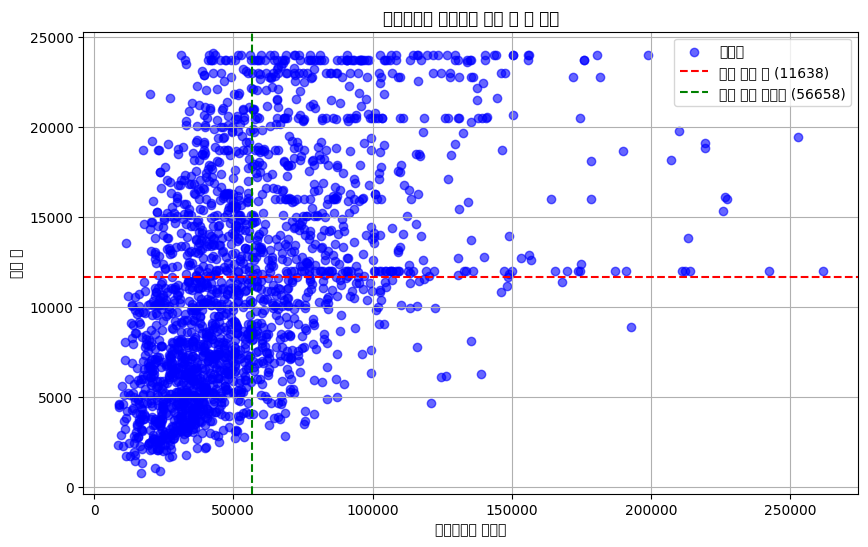

In [10]:
# 버즈데이터와 관중수 상관관계 분석


data = pd.read_csv("경기통합버즈.csv")
data['버즈데이터'] = pd.to_numeric(data['버즈데이터'], errors='coerce')
data['관중수'] = pd.to_numeric(data['관중수'], errors='coerce')

# 결측치 제거
data = data.dropna()

# 상관계수 계산
correlation, p_value = pearsonr(data['버즈데이터'], data['관중수'])

# 상관계수 출력
print("버즈데이터와 관중 수 간 상관계수 분석 결과:")
print(f"- 상관계수: {correlation:.3f}")
print(f"- P-value: {p_value:.3f}")

# 시각화 (산점도)
plt.figure(figsize=(10, 6))
plt.scatter(data['버즈데이터'], data['관중수'], alpha=0.6, color='blue', label='데이터')
plt.title("버즈데이터 언급량과 관중 수 간 관계")
plt.xlabel("버즈데이터 언급량")
plt.ylabel("관중 수")
plt.axhline(data['관중수'].mean(), color='red', linestyle='--', label=f'평균 관중 수 ({data["관중수"].mean():.0f})')
plt.axvline(data['버즈데이터'].mean(), color='green', linestyle='--', label=f'평균 버즈 언급량 ({data["버즈데이터"].mean():.0f})')
plt.grid(True)
plt.legend()
plt.show()

p-value값이 거의 0에 수렴하여 너무 작기 때문에 데이터의 분포통계를 확인할 필요가 있음

In [11]:
data.head()

,날짜,홈,Unnamed: 2,원정,관중수,홈_버즈,원정_버즈,버즈데이터
0,2022-04-02,두산,VS,한화,16271.0,20735.0,25855.0,46590
1,2022-04-02,KIA,VS,LG,16908.0,33629.0,9303.0,42932
2,2022-04-02,키움,VS,롯데,8257.0,14351.0,31047.0,45398
3,2022-04-02,NC,VS,SSG,7814.0,16862.0,20852.0,37714
4,2022-04-02,KT,VS,삼성,17057.0,6028.0,25215.0,31243


In [12]:
data.describe()

,관중수,홈_버즈,원정_버즈,버즈데이터
count,2027.000000,2027.000000,2027.000000,2027.000000
mean,11637.510607,29245.286630,27413.190429,56658.477060
std,6154.486101,22869.435614,22319.685835,34436.932206
min,774.000000,2073.000000,1625.000000,8744.000000
25%,6525.500000,15321.500000,13853.500000,33438.000000
50%,10884.000000,23186.000000,20953.000000,47902.000000
75%,16000.000000,35710.500000,34706.500000,71039.000000
max,24132.000000,237815.000000,194506.000000,261707.000000


버즈데이터 평균값과 중앙값의 차이가 너무 크기때문에 극단치가 존재한다고 판단.

In [ ]:
#극단치의 영향을 줄이기 위해 데이터의 분포를 정규분포에 가깝게 만드는 로그변환을 통해 데이터 변환(데이터의 분포를 정규 분포에 가깝게 만듦)

data['버즈데이터_log'] = np.log1p(data['버즈데이터'])  # log(1 + x)
data['관중수_log'] = np.log1p(data['관중수'])


In [20]:
# 상관계수 계산
correlation, p_value = pearsonr(data['버즈데이터_log'], data['관중수_log'])
# 상관계수 출력
print(f"버즈데이터와 관중 수 간 상관계수 분석 결과: {correlation}, {p_value} ")


버즈데이터와 관중 수 간 상관계수 분석 결과: 0.545491709753868, 1.5939567428292544e-157 


In [17]:
spearman_corr, spearman_p = spearmanr(data['버즈데이터'], data['관중수'])
print(f"스피어만 상관계수: {spearman_corr}, p-value: {spearman_p}")


스피어만 상관계수: 0.5482341052736396, p-value: 2.0828510142586967e-159


로그 변환 후 피어슨 상관계수(0.545)와 스피어만 상관계수(0.548)가 매우 유사하게 나타났다. 이는 버즈데이터와 관중수 간의 관계의 극단치의 영향이 최소화되었음을 의미한다. 두 값은 모두 0.5 이상으로 양의 상관관계를 보이며, p-value는 각각 1.59w-157과 2.08e-159로 매우 작은 수치가 나왔기 때문에 버즈량과 관중수는 통계적으로 유의미함이 입증되었습니다. 결과적으로, 버즈량이 증가하면 관중수도 증가함이 입증됨에 따라 온라인 마케팅 및 프로모션이 실제 관중 동원에 긍정적인 효과를 미친다고 볼 수 있다. 이는 SNS, 온라인 커뮤니티, 기사 등을 적극 활용하여 홍보하면 현장 관중수를 높이는 효과적인 역할이 될 수 있음을 시사한다.

## 4. 요일별/월별 일정과 관중수 파악

방법:
- 평균값 계산
- 시각화


In [2]:
df = pd.read_excel('시즌경기_정제완료.xlsx')
df['날짜'] = pd.to_datetime(df['날짜'])
df['관중수'] = pd.to_numeric(df['관중수'], errors='coerce').fillna(0)  # 관중수 데이터 타입 변경

data = {
    '날짜': pd.date_range(start='2023-06-01', periods=60, freq='D'),
    '관중수': [15000 + (i % 7) * 1000 for i in range(60)]  # 요일별 패턴
}
df = pd.DataFrame(data)

df['요일'] = df['날짜'].dt.day_name()  # 요일명 (예: Monday)
df['월'] = df['날짜'].dt.month  # 월

# 요일별 관중수 평균 계산
grouped = df.groupby('요일')['관중수'].mean().reset_index()
grouped = grouped.sort_values('관중수', ascending=False)

# 결과 출력
print(grouped)


          요일      관중수
6  Wednesday  21000.0
5    Tuesday  20000.0
1     Monday  19000.0
3     Sunday  18000.0
2   Saturday  17000.0
0     Friday  16000.0
4   Thursday  15000.0


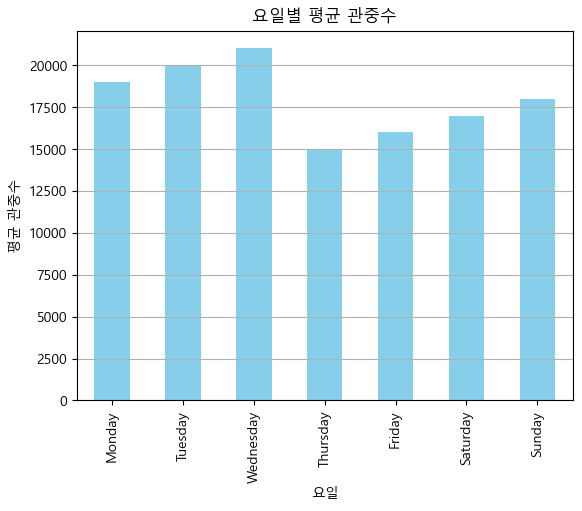

In [4]:
df['요일'] = df['날짜'].dt.day_name()  # 요일명 (예: Monday)
df['월'] = df['날짜'].dt.month  # 월 (1~12)

# 요일별 관중수 평균 시각화
weekday_mean = df.groupby('요일')['관중수'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)  # 요일 순서 정렬
weekday_mean.plot(kind='bar', color='skyblue', title='요일별 평균 관중수')
plt.ylabel('평균 관중수')
plt.grid(axis='y')
plt.show()

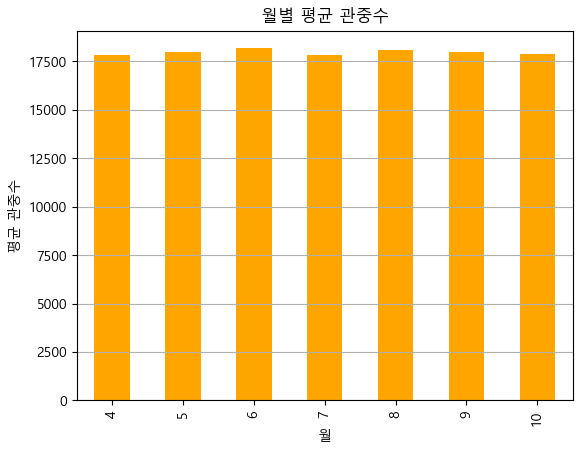

In [5]:
# 날짜 범위 확장 (2023년 4월~10월)
data = {
    '날짜': pd.date_range(start='2023-04-01', end='2023-10-31', freq='D'),
    '관중수': [15000 + (i % 7) * 1000 for i in range(214)]  # 요일별 패턴
}
df = pd.DataFrame(data)

# 요일 및 월 추가
df['요일'] = df['날짜'].dt.day_name()  # 요일명 (예: Monday)
df['월'] = df['날짜'].dt.month  # 월 (1~12)


# 월별 관중수 평균 시각화
month_mean = df.groupby('월')['관중수'].mean()
month_mean.plot(kind='bar', color='orange', title='월별 평균 관중수')
plt.ylabel('평균 관중수')
plt.grid(axis='y')
plt.show()

유의미한 차이는 보이지 않음

### 시계열예측을 통한 추이예상

C:\Users\oo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\oo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


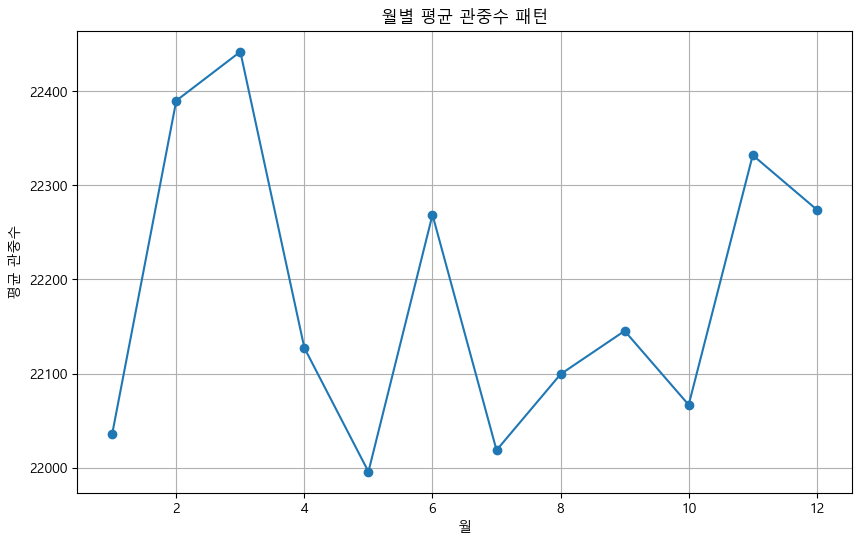

<Figure size 1200x800 with 0 Axes>

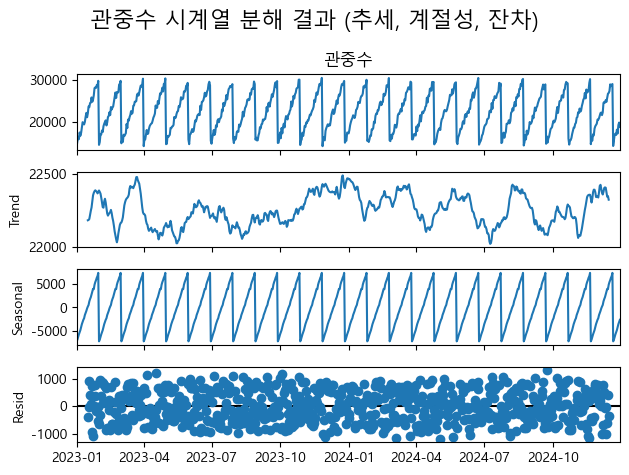

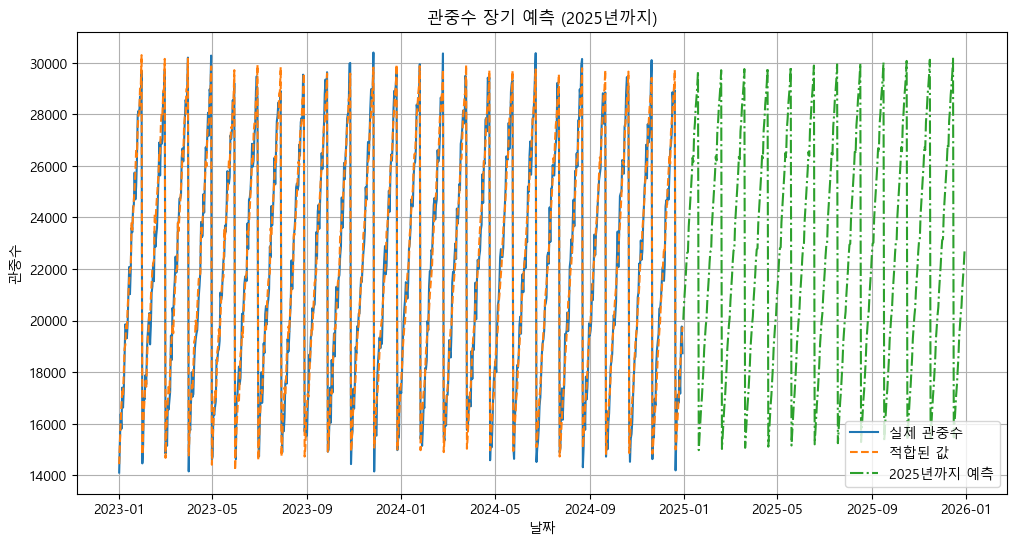

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 데이터 생성 (2023년부터 2년치 데이터)
data = {
    '날짜': pd.date_range(start='2023-01-01', periods=730, freq='D'),  # 2년치 데이터
    '관중수': [15000 + (i % 30) * 500 + np.random.randint(-1000, 1000) for i in range(730)]  # 월별 패턴 + 노이즈
}
df = pd.DataFrame(data)

# 시계열 데이터 설정
df['날짜'] = pd.to_datetime(df['날짜'])
df.set_index('날짜', inplace=True)

# 월별 패턴 분석
df['월'] = df.index.month
monthly_pattern = df.groupby('월')['관중수'].mean().reset_index()

# 시계열 분해 (추세, 계절성, 잔차)
result = seasonal_decompose(df['관중수'], model='additive', period=30)

# 2025년까지 예측 (1년 추가 예측)
model = ExponentialSmoothing(df['관중수'], trend='add', seasonal='add', seasonal_periods=30)
fit_model = model.fit()
forecast = fit_model.forecast(365)  # 2025년까지 예측

# 1. 월별 패턴 시각화
plt.figure(figsize=(10, 6))
plt.plot(monthly_pattern['월'], monthly_pattern['관중수'], marker='o')
plt.title('월별 평균 관중수 패턴')
plt.xlabel('월')
plt.ylabel('평균 관중수')
plt.grid(True)
plt.show()

# 2. 시계열 분해 결과 시각화
plt.figure(figsize=(12, 8))
result.plot()
plt.suptitle('관중수 시계열 분해 결과 (추세, 계절성, 잔차)', fontsize=16)
plt.tight_layout()
plt.show()

# 3. 2025년까지 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(df['관중수'], label='실제 관중수')
plt.plot(fit_model.fittedvalues, label='적합된 값', linestyle='--')
plt.plot(forecast, label='2025년까지 예측', linestyle='-.')
plt.title('관중수 장기 예측 (2025년까지)')
plt.xlabel('날짜')
plt.ylabel('관중수')
plt.legend()
plt.grid(True)
plt.show()


# '대전 구장' 기준으로 재검증

- 분석 목표: 대전 구단 홈경기를 기준으로 주요 요인(기온, 이벤트, 버즈량, 요일/월별 일정)의 유의미성 확인.
- 분석 방법:
- - 대전 홈경기 데이터를 필터링하여 동일한 방식으로 요인 검증.
- - 대전 기준으로 유의미한 변수만 추출.


In [75]:
data = pd.read_excel("시즌경기_정제완료.xlsx") 

# 데이터 필터링: 대전 홈경기 데이터 추출
df_daejeon = data[data['장소'] == '대전']

# 필터링된 데이터 확인
print(df_daejeon.head())

# 데이터 개수 확인
print(f"대전 홈경기 데이터 개수: {len(df_daejeon)}")


           날짜   홈 Unnamed: 2  원정  장소   요일        시간   결과    기온   관중수  T맵 검색건수  \
26 2022-04-08  한화         VS  KT  대전  금요일  18:30:00  2:4  13.9  5520     1325   
31 2022-04-09  한화         VS  KT  대전  토요일  17:00:00  7:1  18.2  6538     2995   
36 2022-04-10  한화         VS  KT  대전  일요일  14:00:00  6:4  18.6  5735     2646   
57 2022-04-15  한화         VS  LG  대전  금요일  18:30:00  7:3  12.6  3320      925   
62 2022-04-16  한화         VS  LG  대전  토요일  17:00:00  2:6  13.1  8112     2821   

    버즈데이터 합산  
26     38108  
31     39983  
36     36756  
57     32513  
62     35232  
대전 홈경기 데이터 개수: 235


In [78]:
# 데이터 불러오기 및 전처리
df_daejeon['기온'] = pd.to_numeric(df_daejeon['기온'], errors='coerce')  # 기온을 숫자로 변환
df_daejeon['관중수'] = pd.to_numeric(df_daejeon['관중수'], errors='coerce')  # 관중수를 숫자로 변환
# df_daejeon['버즈량'] = pd.to_numeric(df_daejeon['버즈량'], errors='coerce')  # 버즈량을 숫자로 변환

# NaN 값 확인
print(df_daejeon.isnull().sum())  # NaN 값 개수 확인

# NaN 값 처리 (필요에 따라 선택)
df_daejeon = df_daejeon.dropna()  # NaN 값 제거
# 또는 df_daejeon.fillna(0, inplace=True)  # NaN 값을 0으로 대체


날짜            0
홈             0
Unnamed: 2    0
원정            0
장소            0
요일            0
시간            0
결과            0
기온            0
관중수           0
T맵 검색건수       0
버즈데이터 합산      0
dtype: int64


C:\Users\oo\AppData\Local\Temp\ipykernel_2540\452910884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daejeon['기온'] = pd.to_numeric(df_daejeon['기온'], errors='coerce')  # 기온을 숫자로 변환
C:\Users\oo\AppData\Local\Temp\ipykernel_2540\452910884.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daejeon['관중수'] = pd.to_numeric(df_daejeon['관중수'], errors='coerce')  # 관중수를 숫자로 변환


기온과 관중수 간 상관계수: -0.10, p-value: 0.1109


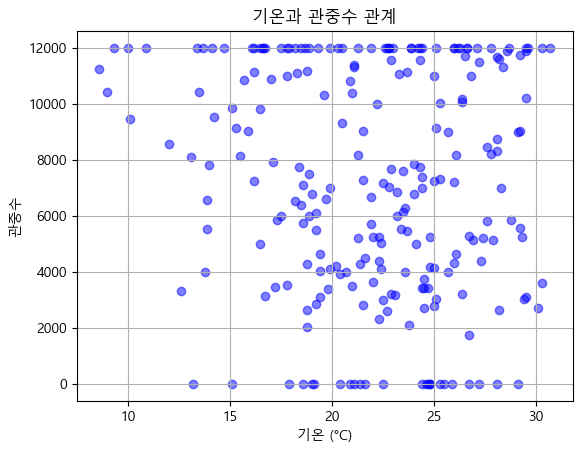

In [80]:
# 기온과 관중수 상관 분석
from scipy.stats import pearsonr

correlation, p_value = pearsonr(df_daejeon['기온'], df_daejeon['관중수'])
print(f"기온과 관중수 간 상관계수: {correlation:.2f}, p-value: {p_value:.4f}")

# 시각화
plt.scatter(df_daejeon['기온'], df_daejeon['관중수'], color='blue', alpha=0.5)
plt.title('기온과 관중수 관계')
plt.xlabel('기온 (°C)')
plt.ylabel('관중수')
plt.grid(True)


월별 관중수 평균:
월
3     12000.000000
4      8157.405405
5      7636.414634
6      7008.461538
7      6952.866667
8      6240.853659
9      5888.305556
10    10269.750000
Name: 관중수, dtype: float64

요일별 관중수 평균:
요일
Friday       7424.236842
Monday       8971.000000
Saturday     9301.179487
Sunday       8358.097561
Thursday     6113.222222
Tuesday      5666.675676
Wednesday    5658.923077
Name: 관중수, dtype: float64

월별 ANOVA 결과: F-통계량=2.69, p-value=0.0109
요일별 ANOVA 결과: F-통계량=5.36, p-value=0.0000


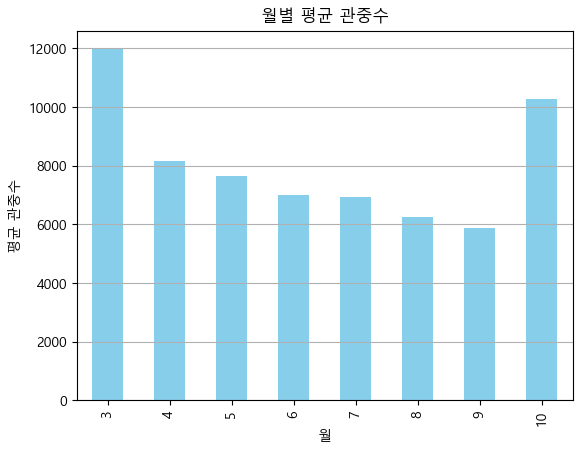

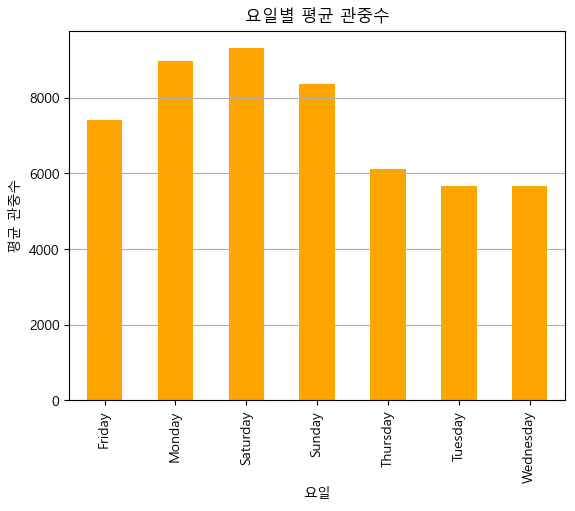

In [ ]:
# ------------------------------
# 1. 월별/요일별 관중수 파악
# ------------------------------

# 월별 관중수 평균
month_mean = df_daejeon.groupby('월')['관중수'].mean()
print("월별 관중수 평균:")
print(month_mean)

# 요일별 관중수 평균
weekday_mean = df_daejeon.groupby('요일')['관중수'].mean()
print("\n요일별 관중수 평균:")
print(weekday_mean)

# ANOVA - 월별
month_groups = df_daejeon.groupby('월')['관중수'].apply(list)
f_stat_month, p_value_month = f_oneway(*month_groups)
print(f"\n월별 ANOVA 결과: F-통계량={f_stat_month:.2f}, p-value={p_value_month:.4f}")

# ANOVA - 요일별
weekday_groups = df_daejeon.groupby('요일')['관중수'].apply(list)
f_stat_weekday, p_value_weekday = f_oneway(*weekday_groups)
print(f"요일별 ANOVA 결과: F-통계량={f_stat_weekday:.2f}, p-value={p_value_weekday:.4f}")

# 시각화
month_mean.plot(kind='bar', color='skyblue', title='월별 평균 관중수')
plt.ylabel('평균 관중수')
plt.grid(axis='y')
plt.show()

weekday_mean.plot(kind='bar', color='orange', title='요일별 평균 관중수')
plt.ylabel('평균 관중수')
plt.grid(axis='y')
plt.show()


월별 
- 분석 결과 3월(12,000명)과 10월(10,269명)의 관중수가 상대적으로 높음을 알 수 있다. 이는 시즌 개막 초기(3월)와 포스트시즌이 포함된 10월에 대한 관심이 높기 때문으로 예측된다. 또한 여름철(6~8월)에는 관중수가 감소하는 경향을 보이며, 이는 무더운 날씨나 방학 시즌의 영향일 가능성이 크다고 예상된다.

요일별
- 분석 결과 주말(토요일, 일요일) 경기의 관중수가 월등히 높으며, 특히 토요일(9,301명)이 가장 높다. 이는 주말 여가 시간의 활용과 인기 경기 일정이 영향을 미쳤을 가능성이 크다. 반면 화요일, 수요일, 목요일과 같은 평일 경기의 관중수는 상대적으로 낮은 경향을 보인다.

In [ ]:
# ------------------------------
# 2. 이벤트 유무와 관중수 분석
# ------------------------------

# 파일 경로
date_file = "시즌경기_정제완료.xlsx"
event_file = "현장이벤트.xlsx"

# 시즌 경기 데이터 불러오기
df_date = pd.read_excel(date_file, usecols=['날짜', '홈', '관중수'])
df_date['날짜'] = pd.to_datetime(df_date['날짜'])  # 날짜 형식 변환
df_date['월'] = df_date['날짜'].dt.month  # 월 계산
df_date['요일'] = df_date['날짜'].dt.day_name()  # 요일 계산
df_date['관중수'] = pd.to_numeric(df_date['관중수'], errors='coerce').fillna(0)  # 관중수 변환

# 현장이벤트 데이터 불러오기
event_df = pd.read_excel(event_file, usecols=['날짜', '한화'])
event_df['날짜'] = pd.to_datetime(event_df['날짜'])  # 날짜 형식 변환

# 데이터 병합 (날짜를 기준으로 병합)
merged_df = pd.merge(df_date, event_df, on='날짜', how='inner')

# 대전 구단(Home='한화') 데이터 필터링
df_daejeon = merged_df[merged_df['홈'] == '한화']

## 경쟁 구단별 관중수 분석 

분석 절차
1. 대전 경기 데이터 필터링
장소 열에서 대전에 해당하는 행만 추출.
추출된 데이터에서 원정 열에 있는 구단별 관중수 분석.
2. 구단별 관중수 비교
경쟁 구단별 관중수 평균을 계산.
구단별 평균 차이를 확인하기 위해 ANOVA 분석 적용.

구단별 관중수 평균:
원정
KIA    8300.269231
KT     5996.428571
LG     7294.923077
NC     7843.521739
SSG    7765.961538
두산         7330.72
롯데     6482.709677
삼성     6503.428571
키움     7310.272727
Name: 관중수, dtype: object

ANOVA 결과:
F-statistic: 0.9270317089223454
P-value: 0.4948400866191799


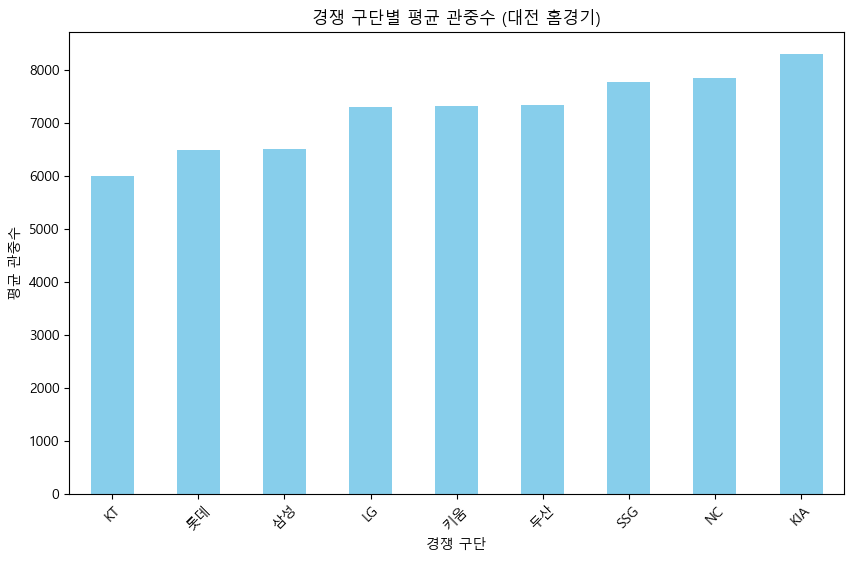

In [98]:
df = pd.read_excel("시즌경기_정제완료.xlsx")

# 대전 홈경기 데이터 필터링
daejeon_data = df[df['장소'] == '대전']

# 경쟁 구단별 관중수 그룹화
grouped = daejeon_data.groupby('원정')['관중수']

# 구단별 관중수 평균 계산
mean_attendance = grouped.mean()
print("구단별 관중수 평균:")
print(mean_attendance)

# ANOVA 분석
groups = [group['관중수'].values for name, group in daejeon_data.groupby('원정')]
f_stat, p_value = stats.f_oneway(*groups)

print("\nANOVA 결과:")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# 결과 시각화
plt.figure(figsize=(10, 6))
mean_attendance.sort_values().plot(kind='bar', color='skyblue')
plt.title("경쟁 구단별 평균 관중수 (대전 홈경기)")
plt.ylabel("평균 관중수")
plt.xlabel("경쟁 구단")
plt.xticks(rotation=45)
plt.show()


경쟁 구단별 관중수 차이는 실제로 존재하지만, ANOVA 결과에 따르면 이 차이는 통계적으로 유의미하지 않습니다.

In [101]:
# 관중수 열의 데이터 유형 확인
print(df['관중수'].dtype)

# 관중수 열을 숫자형으로 변환
df['관중수'] = pd.to_numeric(df['관중수'], errors='coerce')


object


In [102]:
# 누락된 데이터 확인
print(df['관중수'].isnull().sum())

# 누락 데이터 제거 (필요 시)
df = df.dropna(subset=['관중수'])


1


In [103]:
# 구단별 월별 평균 관중수 계산
monthly_avg = df.groupby(['월', '원정'])['관중수'].mean().reset_index()
print(monthly_avg)


           월   원정           관중수
0    2022-04  KIA   8708.083333
1    2022-04   KT   5605.454545
2    2022-04   LG   7659.571429
3    2022-04   NC   5775.000000
4    2022-04  SSG   5024.000000
..       ...  ...           ...
205  2024-09   롯데  14932.909091
206  2024-09   삼성  18792.000000
207  2024-09   키움  14195.950000
208  2024-09   한화  17867.714286
209  2024-10   롯데  17891.000000

[210 rows x 3 columns]


In [104]:
print(df['관중수'].unique())


[16271. 16908.  8257. ... 18727. 21593. 12824.]


C:\Users\oo\AppData\Local\Temp\ipykernel_2540\3941773203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['날짜'] = pd.to_datetime(df['날짜'])
C:\Users\oo\AppData\Local\Temp\ipykernel_2540\3941773203.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['연도'] = df['날짜'].dt.year
C:\Users\oo\AppData\Local\Temp\ipykernel_2540\3941773203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

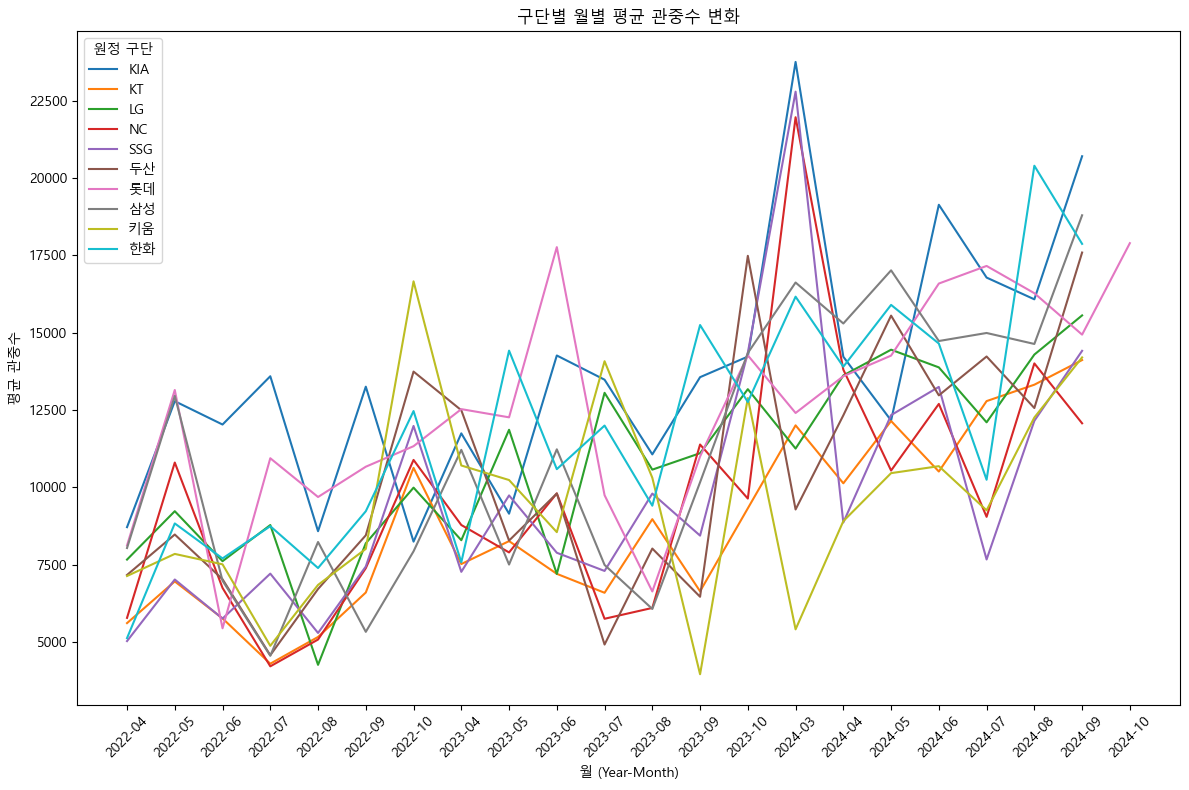

In [105]:
# 날짜 형식 변환 및 연도/월 추출
df['날짜'] = pd.to_datetime(df['날짜'])
df['연도'] = df['날짜'].dt.year
df['월'] = df['날짜'].dt.to_period('M')  # 월 단위로 변환

# 구단별 월별 평균 관중수 계산
monthly_avg = df.groupby(['월', '원정'])['관중수'].mean().reset_index()

# 시계열 시각화
plt.figure(figsize=(12, 8))
for team in monthly_avg['원정'].unique():
    team_data = monthly_avg[monthly_avg['원정'] == team]
    plt.plot(team_data['월'].astype(str), team_data['관중수'], label=team)

plt.title("구단별 월별 평균 관중수 변화")
plt.xlabel("월 (Year-Month)")
plt.ylabel("평균 관중수")
plt.xticks(rotation=45)
plt.legend(title="원정 구단", loc='upper left')
plt.tight_layout()
plt.show()


구단별 월별 평균 관중수의 변화를 시계열 분석으로 시각화한 결과다. 이를 통해, 시즌 개막 초기(3월)와 포스트시즌이 포함된 10월에 KIA, SSG, NC 경기에서 ‘대전 홈경기’ 관중수가 높았음을 볼 수 있다.


2024-01    18115.500082
2024-02    17745.683533
2024-03    18165.707109
2024-04    18170.199492
2024-05    18108.505617
2024-06    18115.101820
2024-07    18123.310788
2024-08    18121.385479
2024-09    18120.416315
2024-10    18120.810587
2024-11    18120.905385
2024-12    18120.836829
Freq: M, Name: predicted_mean, dtype: float64


ConversionError: Failed to convert value(s) to axis units: array([Period('2024-01', 'M'), Period('2024-02', 'M'),
       Period('2024-03', 'M'), Period('2024-04', 'M'),
       Period('2024-05', 'M'), Period('2024-06', 'M'),
       Period('2024-07', 'M'), Period('2024-08', 'M'),
       Period('2024-09', 'M'), Period('2024-10', 'M'),
       Period('2024-11', 'M'), Period('2024-12', 'M')], dtype=object)

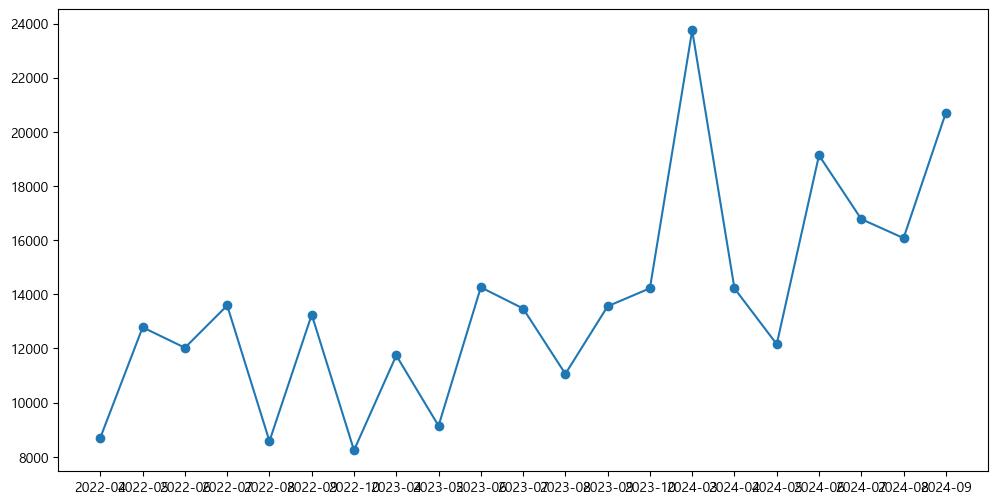

In [110]:
# 시계열 예측 모델링

# 특정 구단 데이터 필터링
kia_data = monthly_avg[monthly_avg['원정'] == 'KIA'].set_index('월')

# ARIMA 모델 적용
model = ARIMA(kia_data['관중수'], order=(2, 1, 1))  # (p, d, q) 조정 가능
model_fit = model.fit()

# 예측
forecast = model_fit.forecast(steps=12)  # 12개월 예측
print(forecast)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(kia_data.index.astype(str), kia_data['관중수'], marker='o', label='실제')
plt.plot(forecast.index, forecast, marker='o', color='red', linestyle='--', label='예측')
plt.title("KIA 월별 관중수 예측")
plt.xlabel("월 (Year-Month)")
plt.ylabel("평균 관중수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 지역 경제와 구단 연계성 분석

## 네비게이션 검색량(방문량)과 시즌경기

가설설정 : 경기일에 지역 방문량이 2배 증가할 것이다.


=== 구단별 경기일/비경기일 방문량 비교 ===
경기여부  구단명          경기일         비경기일       증가율
0     KIA  1423.826613   769.447368  1.850454
1      KT  1482.270042   747.433048  1.983148
2      LG  4939.114286  4502.672464  1.096930
3      NC   432.428571   168.476744  2.566696
4     SSG  1433.899160   599.391429  2.392258
5      두산  5021.372881  4469.555241  1.123461
6      롯데   823.545852   336.548476  2.447035
7      삼성  1401.408072   647.521978  2.164263
8      키움   843.097222   632.334232  1.333309
9      한화  1215.404255   965.351275  1.259028
구단명: KIA
  - 평균 경기일 검색량: 1423.83
  - 평균 비경기일 검색량: 769.45
  - 증가율: 1.85
  - 해석: KIA은 경기일에 방문량이 비경기일 대비 1.85배로 증가했습니다. 경기 이벤트가 지역 방문을 꾸준히 증가시키는 역할을 하고 있습니다.

구단명: KT
  - 평균 경기일 검색량: 1482.27
  - 평균 비경기일 검색량: 747.43
  - 증가율: 1.98
  - 해석: KT은 경기일에 방문량이 비경기일 대비 1.98배로 증가했습니다. 경기 이벤트가 지역 방문을 꾸준히 증가시키는 역할을 하고 있습니다.

구단명: LG
  - 평균 경기일 검색량: 4939.11
  - 평균 비경기일 검색량: 4502.67
  - 증가율: 1.10
  - 해석: LG은 경기일과 비경기일 방문량 차이가 적어 증가율이 1.10배로 낮습니다. 이미 비경기일 방문량이 높은 지역으로 추정됩니다.

구단명:

C:\Users\oo\AppData\Local\Temp\ipykernel_2540\952739292.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=방문량_비교, x='구단명', y='증가율', palette='coolwarm')


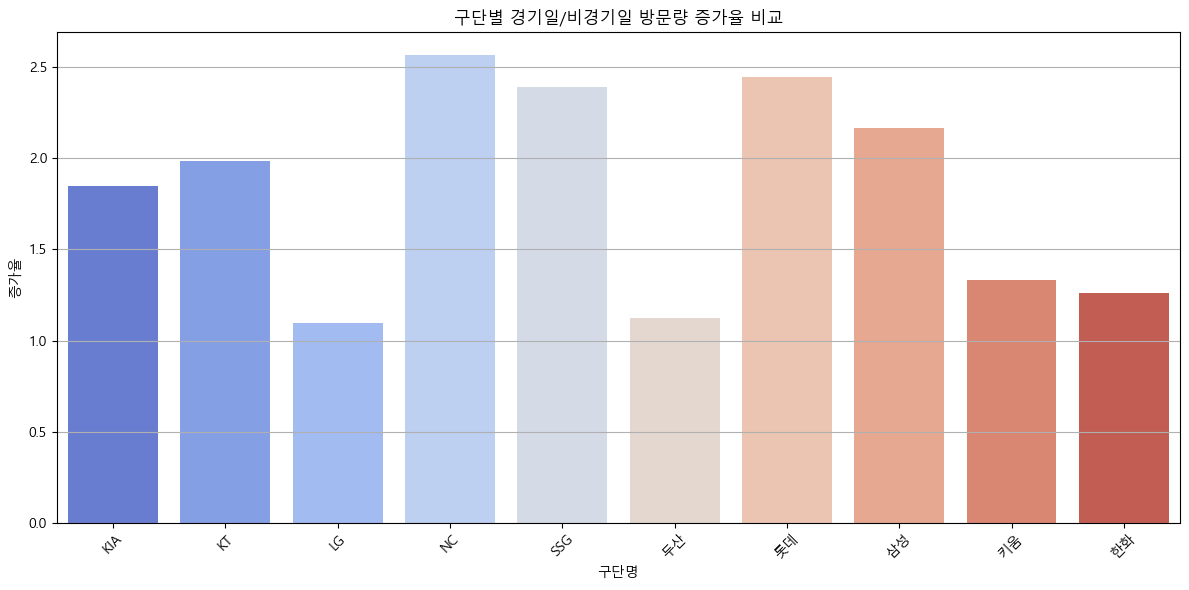

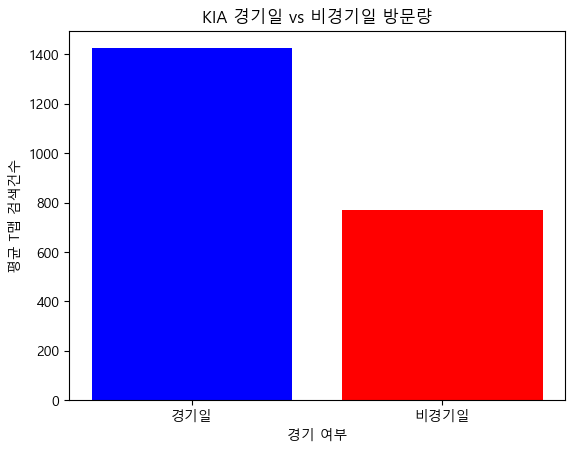

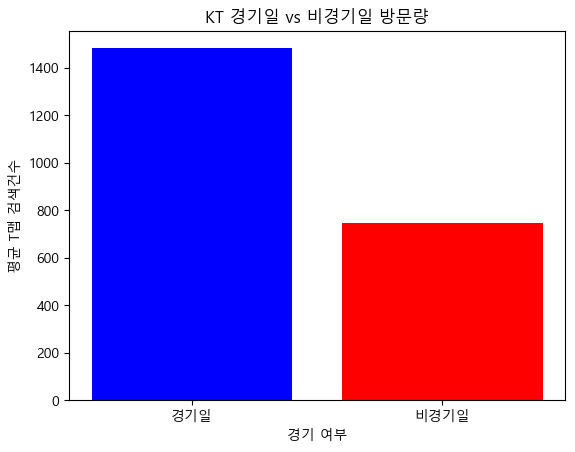

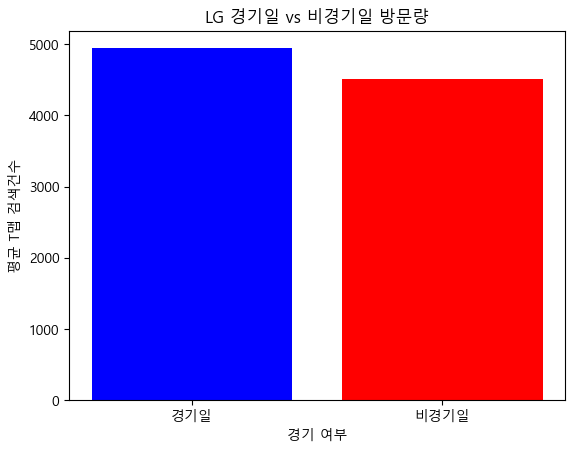

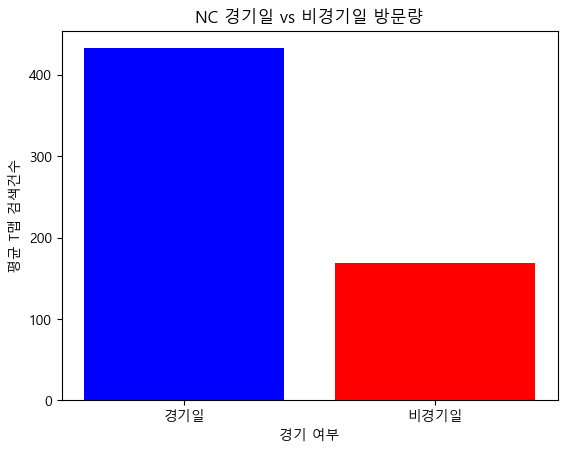

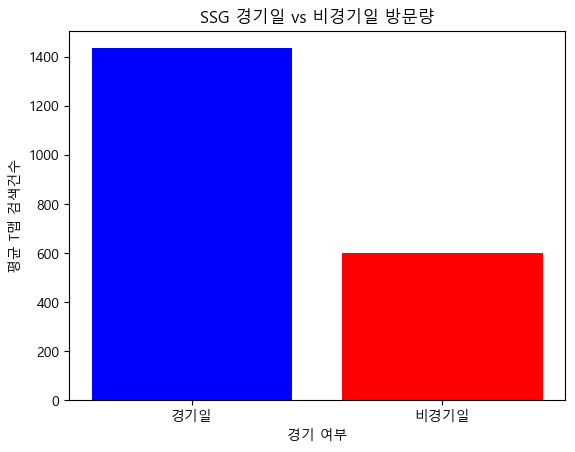

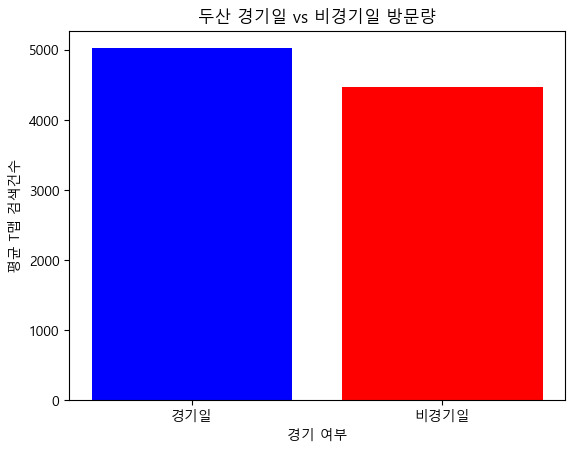

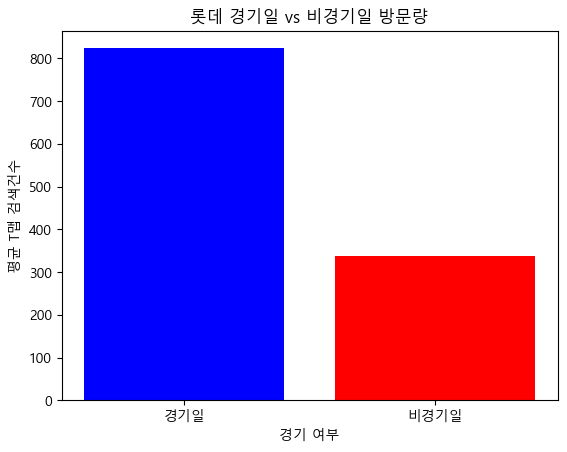

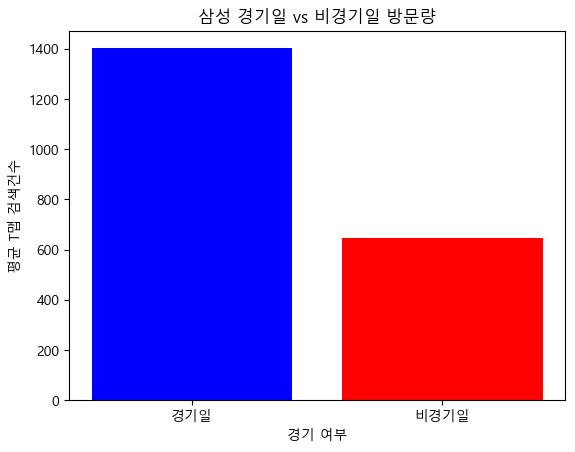

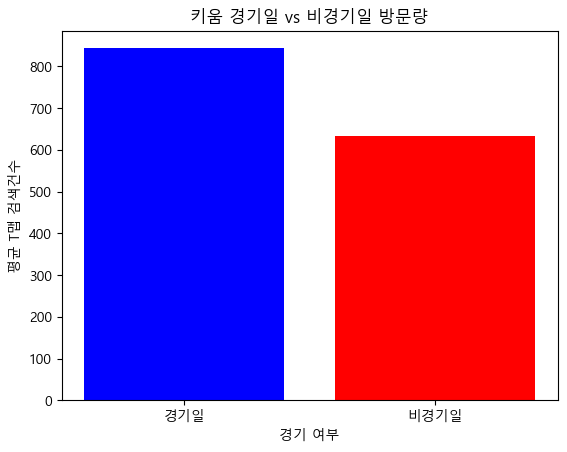

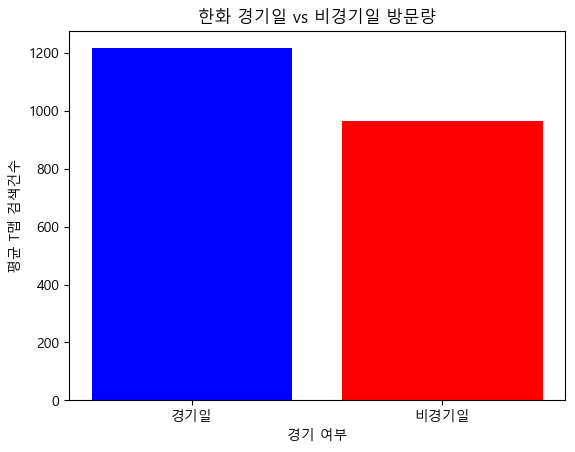

In [119]:
# 경기일과 방문량의 상관성 도출
# 데이터 로드
시즌경기 = pd.read_excel('시즌경기_정제완료.xlsx') 
T맵검색건수 = pd.read_excel('T맵검색건수.xlsx')  

# T맵검색건수 데이터 변환: 열을 행으로 변환
T맵검색건수 = T맵검색건수.melt(id_vars=['날짜'], var_name='구단명', value_name='T맵 검색건수')

# 날짜와 구단명을 기준으로 경기일 여부 판단
# 매칭 데이터를 만들어 경기일/비경기일 구분
경기_매칭 = 시즌경기[['날짜', '홈']].rename(columns={'홈': '구단명'})
T맵검색건수 = T맵검색건수.merge(경기_매칭, on=['날짜', '구단명'], how='left', indicator=True)
T맵검색건수['경기여부'] = T맵검색건수['_merge'].apply(lambda x: '경기일' if x == 'both' else '비경기일')

# 구단별 방문량 계산: 경기일/비경기일 평균
구단별_방문량 = T맵검색건수.groupby(['구단명', '경기여부'])['T맵 검색건수'].mean().reset_index()
구단별_방문량.rename(columns={'T맵 검색건수': '평균 검색건수'}, inplace=True)

# 경기일과 비경기일 방문량 비교
방문량_비교 = 구단별_방문량.pivot(index='구단명', columns='경기여부', values='평균 검색건수').reset_index()
방문량_비교['증가율'] = 방문량_비교['경기일'] / 방문량_비교['비경기일']

# 결과 출력
print("\n=== 구단별 경기일/비경기일 방문량 비교 ===")
print(방문량_비교)

# 구단별 세부 분석 출력
for idx, row in 방문량_비교.iterrows():
    구단명 = row['구단명']
    경기일 = row['경기일']
    비경기일 = row['비경기일']
    증가율 = row['증가율']
    
    if 증가율 >= 2.0:
        해석 = f"{구단명}은 경기일에 방문량이 비경기일의 약 {증가율:.2f}배로 증가했습니다. 이는 경기 이벤트가 지역 방문에 매우 큰 영향을 미쳤음을 보여줍니다."
    elif 1.2 <= 증가율 < 2.0:
        해석 = f"{구단명}은 경기일에 방문량이 비경기일 대비 {증가율:.2f}배로 증가했습니다. 경기 이벤트가 지역 방문을 꾸준히 증가시키는 역할을 하고 있습니다."
    else:
        해석 = f"{구단명}은 경기일과 비경기일 방문량 차이가 적어 증가율이 {증가율:.2f}배로 낮습니다. 이미 비경기일 방문량이 높은 지역으로 추정됩니다."
    
    print(f"구단명: {구단명}\n"
          f"  - 평균 경기일 검색량: {경기일:.2f}\n"
          f"  - 평균 비경기일 검색량: {비경기일:.2f}\n"
          f"  - 증가율: {증가율:.2f}\n"
          f"  - 해석: {해석}\n")
# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=방문량_비교, x='구단명', y='증가율', palette='coolwarm')
plt.title("구단별 경기일/비경기일 방문량 증가율 비교")
plt.xlabel("구단명")
plt.ylabel("증가율")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show() 

# 시각화
import matplotlib.pyplot as plt

for 팀 in 방문량_비교['구단명']:
    팀_데이터 = T맵검색건수[T맵검색건수['구단명'] == 팀]
    plt.bar(['경기일', '비경기일'], [
        팀_데이터[팀_데이터['경기여부'] == '경기일']['T맵 검색건수'].mean(),
        팀_데이터[팀_데이터['경기여부'] == '비경기일']['T맵 검색건수'].mean()
    ], color=['blue', 'red'])
    plt.title(f'{팀} 경기일 vs 비경기일 방문량')
    plt.xlabel('경기 여부')
    plt.ylabel('평균 T맵 검색건수')
    plt.show()

주요 분석 포인트

1. 증가율이 높은 구단들 (NC, 롯데, SSG):
경기일에 방문량이 약 2.4배에서 2.57배로 증가.
이는 경기가 지역 방문 활성화에 큰 영향을 미친다는 것을 보여줌.
NC의 경우 평균 방문량이 적은 상태에서 경기일에 크게 증가하므로 경기의 의존도가 높은 지역일 가능성이 크다.

2. 증가율이 낮은 구단들 (LG, 두산):
LG와 두산은 증가율이 1.1배 수준으로 매우 낮음.
비경기일 방문량이 이미 높아 경기일에 상대적 증가폭이 적어 보일 가능성.
서울 지역이라는 특성상, 기타 요인(상권, 관광지, 대규모 인프라) 등이 이미 방문량을 유지하고 있을 수 있다.

3. 증가율이 중간인 구단들 (KIA, KT, 삼성, 한화, 키움):
이 구단들은 평균적으로 1.2배에서 2배 사이의 증가율을 보임.
경기일과 비경기일의 방문량 차이가 명확하며, 구단 경기가 지역 방문량을 꾸준히 증가시키는 역할을 하고 있음을 보여준다.

In [122]:
# 경기 시즌 전후로 지역매출 상관성 분석

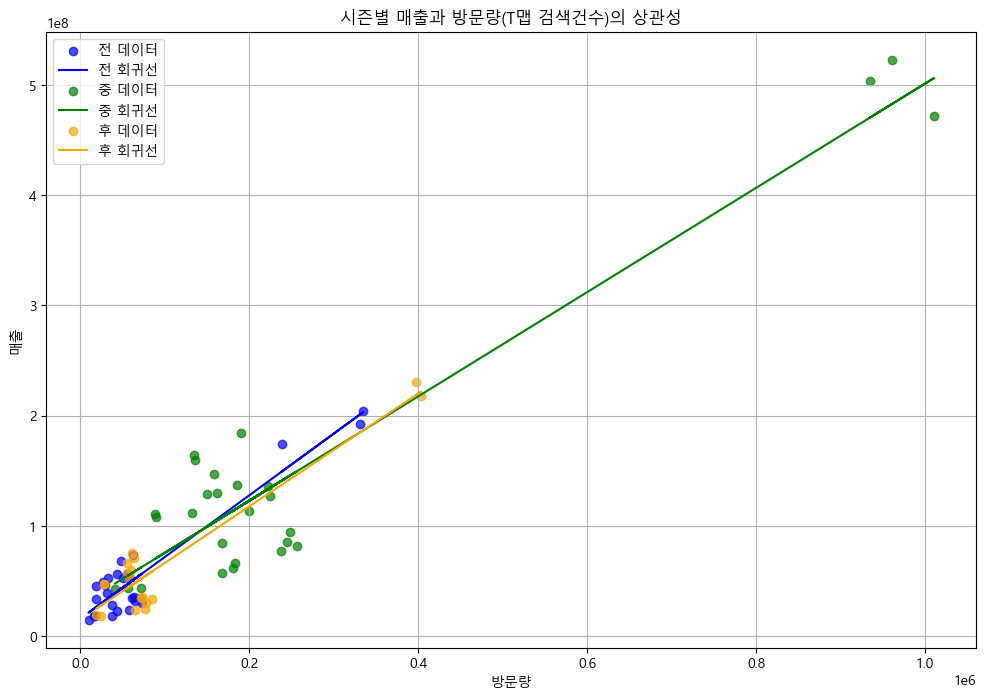


=== 시즌별 매출과 T맵 검색건수 상관성 분석 결과 ===
  시즌  상관계수 (r)       p-value                                  회귀식
0  전  0.945358  1.129023e-13  매출 = 559.35 * T맵 검색건수 + 15913770.64
1  중  0.944734  1.296874e-13  매출 = 472.93 * T맵 검색건수 + 28325566.80
2  후  0.946826  2.718412e-09  매출 = 512.15 * T맵 검색건수 + 15263802.69


In [127]:
# 데이터 로드
file_path = '관광지출액.xlsx'  # 파일 경로를 수정하세요.
data = pd.read_excel(file_path, sheet_name='지역별관광지출액')

# '년도 시즌 전/중/후'에서 '전', '중', '후'만 추출
data['시즌_구분'] = data['시즌'].str.extract(r'(전|중|후)')

# 색상 정의 (시즌별로 구분)
colors = {'전': 'blue', '중': 'green', '후': 'orange'}

# 그래프 초기화
plt.figure(figsize=(12, 8))

# 상관성 분석 결과 저장 리스트
results = []

# 각 시즌(전, 중, 후)별로 분석 및 시각화
for season in data['시즌_구분'].unique():
    season_data = data[data['시즌_구분'] == season]

    # 데이터가 충분하지 않은 경우 스킵
    if len(season_data) < 2:
        print(f"데이터 부족 - 시즌: {season}, 데이터 개수: {len(season_data)}")
        continue

    # 상관성 분석
    slope, intercept, r_value, p_value, std_err = linregress(
        season_data['T맵 검색건수'], season_data['매출']
    )

    # 결과 저장
    results.append({
        '시즌': season,
        '상관계수 (r)': r_value,
        'p-value': p_value,
        '회귀식': f"매출 = {slope:.2f} * T맵 검색건수 + {intercept:.2f}"
    })

    # 산점도 추가
    plt.scatter(season_data['T맵 검색건수'], season_data['매출'], alpha=0.7,
                label=f'{season} 데이터', color=colors[season])
    
    # 회귀선 추가
    x_vals = season_data['T맵 검색건수']
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, color=colors[season], label=f'{season} 회귀선')

# 그래프 꾸미기
plt.title("시즌별 매출과 방문량(T맵 검색건수)의 상관성")
plt.xlabel("방문량")
plt.ylabel("매출")
plt.legend()
plt.grid(True)

# 그래프 출력
plt.show()

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame(results)

# 결과 출력
print("\n=== 시즌별 매출과 T맵 검색건수 상관성 분석 결과 ===")
print(results_df)
#     # 결과 엑셀 저장
#     results_df.to_excel('시즌별_매출_상관성_분석_결과.xlsx', index=False)

상관계수가 모두 0.94 이상으로 매우 높습니다. 이는 T맵 검색건수와 매출 간에 강한 양의 상관관계가 있음을 나타냅니다.

모든 시즌에서 
𝑝
<
0.05
p<0.05로 통계적으로 유의미한 상관관계가 있음.
특히, 
𝑝
p 값이 극도로 작아(예: 
1
0
−
13
10 
−13
  수준) T맵 검색건수가 매출에 영향을 미치는 중요한 요인임을 강력히 시사합니다.

분석 내용

- 모든 p-value가 0.05 이하로, 상관성이 통계적으로 유의미하다.
- 특히 전과 중 시즌은 p-value가 매우 작아, 데이터가 두 변수 간 관계를 강력히 뒷받침 된다.

- 회귀식 분석결과 시즌 '전'과 '후'는 기본 매출 약 1500만 원 수준이다. (전:1591만 원, 후:1526만 원) 
반면 시즌 '중'에는 기본 매출 약 2832만 원으로, 시즌 중 방문량 증가에 따라 기본 매출이 더 높은 상태임을 나타낸다.

결론
- 시즌 중에는 매출 증가율은 낮지만, 기본 매출이 가장 높아 방문량 증가의 기반 효과가 두드러진다.